In [1]:
import numpy as np
#This following is so that this will work with Latex, see
#http://bkanuka.com/articles/native-latex-plots/
import matplotlib as mpl
mpl.use('pgf')

In [2]:
def figsize(scale):                                 # I think scale is the size you want it on the page
    fig_width_pt = 433.62001                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0                        # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_lualatex = {                      # Setup matplotlib to use latex for output
    "pgf.texsystem": "lualatex",           # Change this if using xetex or luatex
    "text.usetex": True,                   # Use LaTeX to write all text
    #Fonts
    "font.family": "serif",                # Get from the pdf font function on the doc
    "font.serif": "Computer Modern Roman",      
    "font.sans-serif": "Computer Modern Sans serif",
    "font.monospace": [], # Blank entries should cause plots to inherit fonts from the document
    #Text size
    "font.size": 11,# Document default is 11pt font.
    #"text.fontsize": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##Axis
    #"axes.labelpad": 2,     # space between label and axis 
    "figure.figsize": figsize(1.0),     # default fig size of 1.0 textwidth
    #Packages
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        r"\usepackage{amsmath}",  #need to add math or the ^ won't work
        r"\usepackage{amssymb}"]
    }

mpl.rcParams.update(pgf_with_lualatex)

In [3]:
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from scipy.integrate import quad
from scipy.special import gamma

In [4]:
%matplotlib inline
pp.style.use('seaborn-ticks')
sns.set_palette("muted")

In [5]:
# Header for loading data
col_names = ['run', 'slug', 'wien', 'asym', 'asym_err', 'asym_n', 'precession', 'wien_state', 'ihwp', 'sign_corr']

In [6]:
# Load data
unreg_data = pd.read_csv('data/al_ntodelta_unregressed.csv', header=None, names=col_names)
reg_data = pd.read_csv('data/al_ntodelta_regressed.csv', header=None, names=col_names)

In [7]:
reg_data.head()

,run,slug,wien,asym,asym_err,asym_n,precession,wien_state,ihwp,sign_corr
0,14337,501001,7,0.238844,1.713094,747597,reverse,reverse,in,-1
1,14338,501002,7,3.084750,1.722954,741990,reverse,reverse,out,1
2,14364,501001,7,-1.868583,1.667716,792191,reverse,reverse,in,-1
3,14365,501002,7,-0.017768,1.798774,684693,reverse,reverse,out,1


In [25]:
def chi2(avg, val, err):
    v_avg = np.ones(len(val))*avg
    weight = 1/np.square(err)
    return np.sum(weight*np.square(v_avg-val)), (len(val)-1)

def calc_chi2(fit, data, err, dof):
    chi2 = np.sum(np.square(data-fit)/np.square(err))
    return chi2, chi2/dof

def chi2probdistribution(chi2, dof):
    if chi2 > 0:
        num = np.power(chi2,(dof-2.0)/2.0)*np.exp(-chi2/2.0)
        dem = np.power(2.0,(dof/2.0))*gamma(dof/2.0)
        return num/dem
    elif chi2 == 0:
        return 0
    else:
        print('Chi^2 values < 0 not valid!')
        
def calc_chi2prob(chi2, dof):
    return quad(chi2probdistribution, chi2, np.inf, (dof))

In [37]:
def ihwp_plot(df, name, prelim=False):
    fig, run_ax = pp.subplots(figsize=figsize(0.9))
    # Allow for Slug top axis
    #slug_ax = run_ax.twiny()

    run_ax.set_xlim(14320, 14380)
    run_ax.set_ylim(-5.0, 5.0)

    left_out = '(wien_state == "reverse") & ihwp == "out"'
    left_in = '(wien_state == "reverse") & ihwp == "in"'
    #right_out = '(wien_state == "normal") & ihwp == "out"'
    #right_in = '(wien_state == "normal") & ihwp == "in"'

    # Plot data versus run number
    run_ax.errorbar(df.query(left_out).run, 
                     df.query(left_out).asym, 
                     yerr=df.query(left_out).asym_err, 
                     ls='None', 
                     marker='^',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull purple'], 
                     label='OUT$_{L}$')

    run_ax.errorbar(df.query(left_in).run, 
                     df.query(left_in).asym, 
                     yerr=df.query(left_in).asym_err, 
                     ls='None', 
                     marker='v',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull orange'], 
                     label='IN$_{L}$')

    #slug_ax.errorbar(df.query(right_out).slug, 
    #                 df.query(right_out).asym, 
    #                 yerr=df.query(right_out).asym_err, 
    #                 ls='None', 
    #                 marker='s',
    #                 capsize=2.0,
    #                 capthick=1.0,
    #                 barsabove=True,
    #                 color=sns.xkcd_rgb['dull red'], 
    #                 label='OUT$_{R}$')

    #slug_ax.errorbar(df.query(right_in).slug, 
    #                 df.query(right_in).asym, 
    #                 yerr=df.query(right_in).asym_err, 
    #                 ls='None', 
    #                 marker='o',
    #                 capsize=2.0,
    #                 capthick=1.0,
    #                 barsabove=True,
    #                 color=sns.xkcd_rgb['dull blue'], 
    #                 label='IN$_{R}$')

    # Calculate & Plot AVGs
    out_avg, out_sow = np.average(df[df['ihwp'] == 'out'].asym, 
                                  weights=1/np.square(df[df['ihwp'] == 'out'].asym_err), 
                                  returned=True)
    out_chi2, out_dof = chi2(out_avg, df[df['ihwp'] == 'out'].asym, df[df['ihwp'] == 'out'].asym_err)
    out_prob = calc_chi2prob(out_chi2, out_dof)
    run_ax.plot(run_ax.get_xlim(), 
                 [out_avg, out_avg], 
                 ls='-',
                 zorder=-10,
                 color=sns.xkcd_rgb['grey'])
    run_ax.fill_between(run_ax.get_xlim(), 
                         out_avg+(1/np.sqrt(out_sow)), 
                         out_avg-(1/np.sqrt(out_sow)), 
                         color=sns.xkcd_rgb['grey'], 
                         alpha=0.2)
    in_avg, in_sow = np.average(df[df['ihwp'] == 'in'].asym, 
                                  weights=1/np.square(df[df['ihwp'] == 'in'].asym_err), 
                                  returned=True)
    in_chi2, in_dof = chi2(in_avg, df[df['ihwp'] == 'in'].asym, df[df['ihwp'] == 'in'].asym_err)
    in_prob = calc_chi2prob(in_chi2, in_dof)
    run_ax.plot(run_ax.get_xlim(), 
                 [in_avg, in_avg], 
                 ls='-',
                 zorder=-10,
                 color=sns.xkcd_rgb['grey'])
    run_ax.fill_between(run_ax.get_xlim(), 
                         in_avg+(1/np.sqrt(in_sow)), 
                         in_avg-(1/np.sqrt(in_sow)), 
                         color=sns.xkcd_rgb['grey'], 
                         alpha=0.2)
    null_avg, null_sow = np.average([out_avg, in_avg], 
                                    weights=[out_sow, in_sow],
                                    returned=True)

    print('OUT Avg. {0:.5}+-{1:.5}     Chi2:{2:.5}     Prob:{3:.5}'.format(out_avg, 1/np.sqrt(out_sow), out_chi2/out_dof, out_prob[0]))
    print('IN Avg. {0:.5}+-{1:.5}     Chi2:{2:.5}     Prob:{3:.5}'.format(in_avg, 1/np.sqrt(in_sow), in_chi2/in_dof, in_prob[0]))
    print('Null {0:.5}+-{1:.5}'.format((out_avg+in_avg)/2, 1/np.sqrt(null_sow)))


    # Labels for slug plot axes
    run_ax.set_xlabel('Time (Run)')
    run_ax.set_ylabel('Asymmetry [ppm]')
    run_ax.ticklabel_format(useOffset=False)
    run_ax.tick_params(top=False)
    # Increase number of minor ticks
    run_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    run_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # Configure Slug "top" axis
    #slug_ax.xaxis.set_ticks_position('top')
    #slug_ax.xaxis.set_label_position('top')
    #slug_ax.set_frame_on(True)
    #slug_ax.set_visible(True)
    #slug_ax.spines['left'].set_visible(False)
    #slug_ax.spines['right'].set_visible(False)
    #slug_ax.spines['bottom'].set_visible(False)
    #run_ax.spines['top'].set_visible(False)
    #slug_ax.spines['top'].set_visible(True)
    # Set Slug axis limits
    #slug_ax.set_xlim(run_ax.get_xlim())
    # Set Slug axis major tick locations
    ##wien_major_pos = [1027.5, 1032.5, 1043.5, 1058.5]
    #wien_ax.set_xticks(wien_major_pos)
    #wien_ax.set_xticklabels('')
    # Set Wien axis minor tick locations with labels
    #wien_ax.set_xticks([1030, 1038, 1051], minor=True)
    #wien_ax.set_xticklabels(['(g-2 flip)\n 6', '8', '9'], minor=True)
    # Zero length to Wien axis minor ticks
    #wien_ax.tick_params(which='minor', length=0)
    # Allow grid for Wien axis major ticks
    #wien_ax.grid(True, which='major')
    #wien_ax.set_xlabel('Time (Wien)')
    # Legend
    run_ax.legend(bbox_to_anchor=(1.2, 1))
    # Preliminary Tag
    if prelim == True:
        pp.text(14350, 
                0.0, 
                'Preliminary', 
                fontsize=72, 
                rotation=31.717, 
                verticalalignment='center', 
                horizontalalignment='center', 
                color=sns.xkcd_rgb['dark grey'], 
                alpha=0.2)
    # Save Plots
    pp.savefig('plots/' + name + '_ihwp.png', bbox_inches='tight')
    pp.savefig('plots/' + name + '_ihwp.pdf', bbox_inches='tight')
    pp.savefig('plots/' + name + '_ihwp.pgf', bbox_inches='tight')
    return

In [38]:
def sign_corrected_plot(df, name, prelim=False):
    fig, run_ax = pp.subplots(figsize=figsize(0.9))
    # Allow for Wien top axis
    #wien_ax = slug_ax.twiny()

    run_ax.set_xlim(14320, 14380)
    run_ax.set_ylim(-3.0, 5.0)

    #left_out = '(wien_state == "reverse") & ihwp == "out"'
    #left_in = '(wien_state == "reverse") & ihwp == "in"'
    left_out_g2 = '(precession == "reverse" & wien_state == "reverse") & ihwp == "out"'
    left_in_g2 = '(precession == "reverse" & wien_state == "reverse") & ihwp == "in"'
    #right_out = '(precession == "normal" & wien_state == "normal") & ihwp == "out"'
    #right_in = '(precession == "normal" & wien_state == "normal") & ihwp == "in"'
    #right_out_g2 = '(precession == "reverse" & wien_state == "normal") & ihwp == "out"'
    #right_in_g2 = '(precession == "reverse" & wien_state == "normal") & ihwp == "in"'

    # Plot data versus slug number
    run_ax.errorbar(df.query(left_out_g2).run, 
                     df.query(left_out_g2).asym, 
                     yerr=df.query(left_out_g2).asym_err, 
                     ls='None', 
                     marker='^',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull purple'], 
                     label='OUT$_{L}$')

    run_ax.errorbar(df.query(left_in_g2).run, 
                     -1.0*df.query(left_in_g2).asym, 
                     yerr=df.query(left_in_g2).asym_err, 
                     ls='None', 
                     marker='v',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull orange'], 
                     label='IN$_{L}$')

    #slug_ax.errorbar(df.query(right_out).slug, 
    #                 df.query(right_out).asym, 
    #                 yerr=df.query(right_out).asym_err, 
    #                 ls='None', 
    #                 marker='s',
    #                 capsize=2.0,
    #                 capthick=1.0,
    #                 barsabove=True,
    #                 color=sns.xkcd_rgb['dull red'], 
    #                 label='OUT$_{R}$')

    #slug_ax.errorbar(df.query(right_in).slug, 
    #                 -1.0*df.query(right_in).asym, 
    #                 yerr=df.query(right_in).asym_err, 
    #                 ls='None', 
    #                 marker='o',
    #                 capsize=2.0,
    #                 capthick=1.0,
    #                 barsabove=True,
    #                 color=sns.xkcd_rgb['dull blue'], 
    #                 label='IN$_{R}$')
    
    #slug_ax.errorbar(df.query(right_out_g2).slug, 
    #                 -1.0*df.query(right_out_g2).asym, 
    #                 yerr=df.query(right_out_g2).asym_err, 
    #                 ls='None', 
    #                 marker='s',
    #                 capsize=2.0,
    #                 capthick=1.0,
    #                 barsabove=True,
    #                 color=sns.xkcd_rgb['dull red'], label=None)
    
    #slug_ax.errorbar(df.query(right_in_g2).slug, 
    #                 df.query(right_in_g2).asym, 
    #                 yerr=df.query(right_in_g2).asym_err, 
    #                 ls='None', 
    #                 marker='o',
    #                 capsize=2.0,
    #                 capthick=1.0,
    #                 barsabove=True,
    #                 color=sns.xkcd_rgb['dull blue'], label=None)

    # Calculate & Plot AVGs
    sign_corrected_asym = np.concatenate([df.query(left_out_g2).asym, -1.0*df.query(left_in_g2).asym])
    sign_corrected_asym_err = np.concatenate([df.query(left_out_g2).asym_err, df.query(left_in_g2).asym_err])
    avg, sow = np.average(sign_corrected_asym, 
                          weights=1/np.square(sign_corrected_asym_err), 
                          returned=True)
    sc_chi2, dof = chi2(avg, sign_corrected_asym, sign_corrected_asym_err)
    sc_prob = calc_chi2prob(sc_chi2, dof)
    run_ax.plot(run_ax.get_xlim(), 
                 [avg, avg], 
                 ls='-',
                 zorder=-10,
                 color=sns.xkcd_rgb['grey'])
    run_ax.fill_between(run_ax.get_xlim(), 
                         avg+(1/np.sqrt(sow)), 
                         avg-(1/np.sqrt(sow)), 
                         color=sns.xkcd_rgb['grey'], 
                         alpha=0.2)

    print('Avg. {0:.5}+-{1:.5}     Chi2:{2:.5}      Prob:{3:.5}'.format(avg, 1/np.sqrt(sow), sc_chi2/dof, sc_prob[0]))

    # Labels for slug plot axes
    run_ax.set_xlabel('Time (Run)')
    run_ax.set_ylabel('Asymmetry [ppm]')
    run_ax.ticklabel_format(useOffset=False)
    run_ax.tick_params(top=False)
    # Increase number of minor ticks
    run_ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    run_ax.yaxis.set_minor_locator(AutoMinorLocator(4))    
    # Configure Wien "top" axis
    #wien_ax.xaxis.set_ticks_position('top')
    #wien_ax.xaxis.set_label_position('top')
    #wien_ax.set_frame_on(True)
    #wien_ax.set_visible(True)
    #wien_ax.spines['left'].set_visible(False)
    #wien_ax.spines['right'].set_visible(False)
    #wien_ax.spines['bottom'].set_visible(False)
    #slug_ax.spines['top'].set_visible(False)
    #wien_ax.spines['top'].set_visible(True)
    # Set Wien axis limits
    #wien_ax.set_xlim(slug_ax.get_xlim())
    # Set Wien axis major tick locations
    #wien_major_pos = [1027.5, 1032.5, 1043.5, 1058.5]
    #wien_ax.set_xticks(wien_major_pos)
    #wien_ax.set_xticklabels('')
    # Set Wien axis minor tick locations with labels
    #wien_ax.set_xticks([1030, 1038, 1051], minor=True)
    #wien_ax.set_xticklabels(['(g-2 flip)\n 6', '8', '9'], minor=True)
    # Zero length to Wien axis minor ticks
    #wien_ax.tick_params(which='minor', length=0)
    # Allow grid for Wien axis major ticks
    #wien_ax.grid(True, which='major')
    #wien_ax.set_xlabel('Time (Wien)')
    # Legend
    run_ax.legend(bbox_to_anchor=(1.2, 1))
    # Preliminary Tag
    if prelim == True:
        pp.text(14350, 
                avg, 
                'Preliminary', 
                fontsize=72, 
                rotation=31.717, 
                verticalalignment='center', 
                horizontalalignment='center', 
                color=sns.xkcd_rgb['dark grey'], 
                alpha=0.2)
    # Save Plots
    pp.savefig('plots/' + name + '_sign_corrected.png', bbox_inches='tight')
    pp.savefig('plots/' + name + '_sign_corrected.pdf', bbox_inches='tight')
    pp.savefig('plots/' + name + '_sign_corrected.pgf', bbox_inches='tight')
    return

OUT Avg. 1.3717+-1.2475     Chi2:1.5703     Prob:0.21016
IN Avg. -1.2962+-1.1981     Chi2:0.51769     Prob:0.47183
Null 0.037744+-0.86413


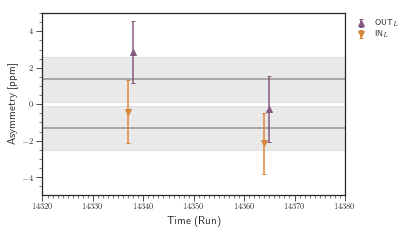

In [39]:
ihwp_plot(unreg_data, 'al_ntodelta_unregressed', False)

Avg. 1.3324+-0.86413     Chi2:0.69664      Prob:0.55396


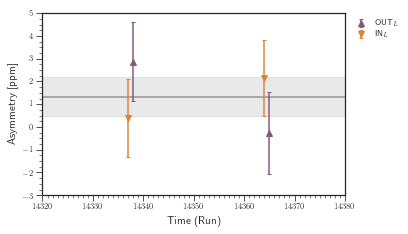

In [40]:
sign_corrected_plot(unreg_data, 'al_ntodelta_unregressed', False)

OUT Avg. 1.6003+-1.2443     Chi2:1.5515     Prob:0.21292
IN Avg. -0.84315+-1.195     Chi2:0.77699     Prob:0.37806
Null 0.37855+-0.86187


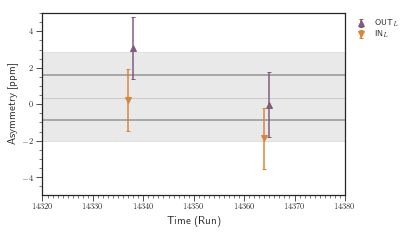

In [41]:
ihwp_plot(reg_data, 'al_ntodelta_regressed', False)

Avg. 1.2064+-0.86187     Chi2:0.84036      Prob:0.4715


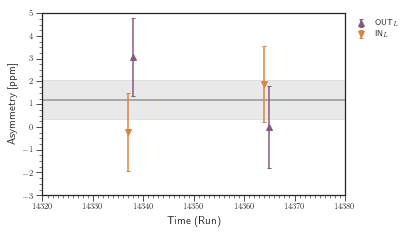

In [42]:
sign_corrected_plot(reg_data, 'al_ntodelta_regressed', False)